<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# ForestDML, ForestDRLearner, OrthoForest and CausalForest: Basic Example

We depict the performance of our `ForestDML`, `ForestDRLearner`, `OrthoForest` and `CausalForest` estimators on the same data generating process as the one used in the tutorial page of the grf package (see https://github.com/grf-labs/grf#usage-examples). This is mostly for qualitative comparison and verification purposes among our implementation of variants of Causal Forests and the implementation in the grf R package.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# DGP

We use the following data generating process (DGP) from [here](https://github.com/grf-labs/grf#usage-examples):

\begin{align}
X \sim& \text{Normal}(0,\, I_{p})\\
T =& \text{Binomial}(1, .4 + .2 \cdot 1\{X[0] > 0\})\\
Y =& (X[0] \cdot 1\{X[0] > 0\}) \cdot T + X[1] + X[2] \cdot 1\{X[2] < 0\} + \epsilon, &\; \epsilon \sim \text{Normal}(0, 1)\\
\end{align}

We use $p=10$ and draw $n=2000$ samples from this DGP.

In [4]:
import numpy as np
import scipy.special
np.random.seed(123)
n = 2000
p = 10
X = np.random.normal(size=(n, p))
true_propensity = lambda x: .4 + .2 * (x[:, 0] > 0)
true_effect = lambda x: (x[:, 0] * (x[:, 0] > 0))
true_conf = lambda x: x[:, 1] + np.clip(x[:, 2], - np.inf, 0)
T = np.random.binomial(1, true_propensity(X))
Y =  true_effect(X) * T + true_conf(X) + np.random.normal(size=(n,))

### Cross-Validated Forest Nuisance Models

We use forest based estimators (Gradient Boosted Forests or Random Forests) as nuisance models. For the meta-learner versions of our forest based estimators, we also use a generic forest estimator even as a final model. The hyperparameters of the forest models (e.g. number of estimators, max depth, min leaf size) is chosen via cross validation. We also choose among Gradient or Random Forests via cross validation

In [5]:
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso

def first_stage_reg():
    return GridSearchCVList([Lasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                               {'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def first_stage_clf():
    return GridSearchCVList([LogisticRegression(),
                             RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'C': [0.01, .1, 1, 10, 100]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def final_stage():
    return GridSearchCVList([WeightedLasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

In [6]:
model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
model_y

GradientBoostingRegressor(min_samples_leaf=30, n_estimators=50,
                          random_state=123)

In [7]:
model_t = clone(first_stage_clf().fit(X, T).best_estimator_)
model_t

RandomForestClassifier(max_depth=3, min_samples_leaf=10, random_state=123)

# DML Estimators

In [8]:
from econml.dml import ForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDML(model_y=model_y,
                model_t=model_t,
                discrete_treatment=True,
                n_crossfit_splits=3,
                n_estimators=4000,
                subsample_fr='auto',
                min_samples_leaf=10,
                verbose=0,
                min_weight_fraction_leaf=.005)
est.fit(Y, T, X=X)

In [9]:
from econml.dml import NonParamDML
est2 = NonParamDML(model_y=model_y,
                   model_t=model_t,
                   n_splits=3,
                   discrete_treatment=True,
                   model_final=final_stage())
est2.fit(Y, T, X=X)

In [10]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [11]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [12]:
pred2 = est2.effect(X_test)

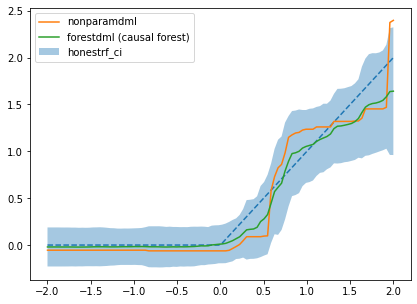

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), '--')
plt.plot(X_test[:, 0], pred2, label='nonparamdml')
plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4, label='honestrf_ci')
plt.legend()
plt.show()

### First Stage Learned Models

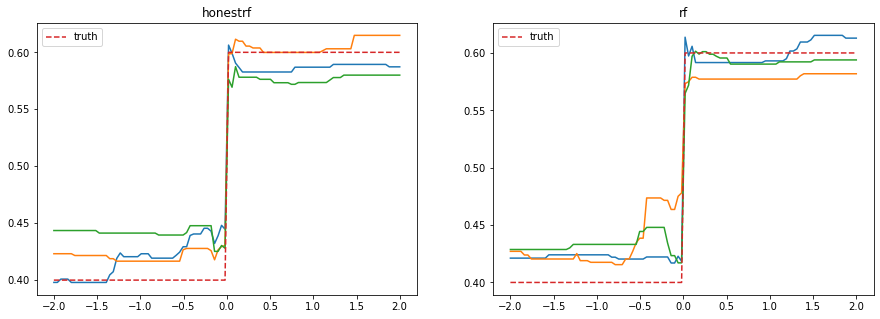

In [14]:
# Model T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_t:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_t:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()
plt.show()

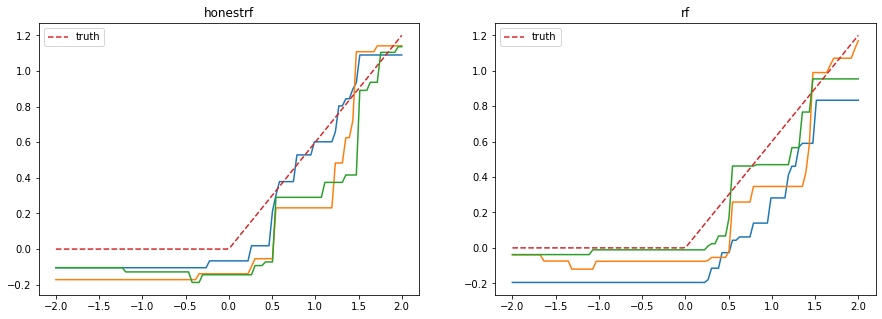

In [15]:
# Model Y
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_y:
    plt.plot(X_test[:, 0], mdl.predict(X_test))
plt.plot(X_test[:, 0], true_effect(X_test) * true_propensity(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_y:
    plt.plot(X_test[:, 0], mdl.predict(X_test))
plt.plot(X_test[:, 0], true_effect(X_test) * true_propensity(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()
plt.show()

### Interpretability of CATE Model of NonParamDML with SHAP

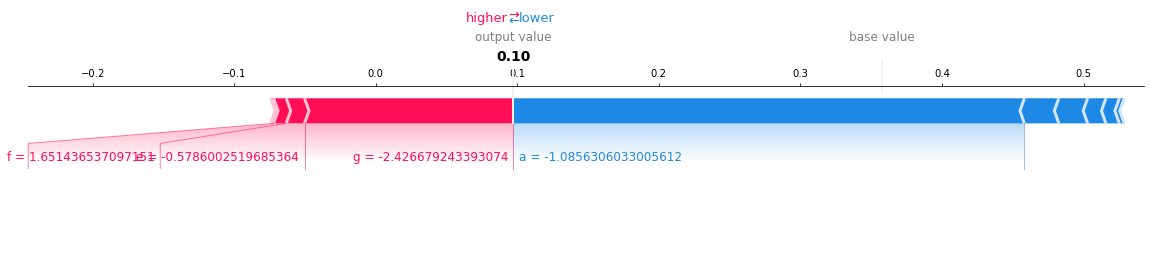

In [16]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_values["Y0"]["T0"][0], matplotlib=True)

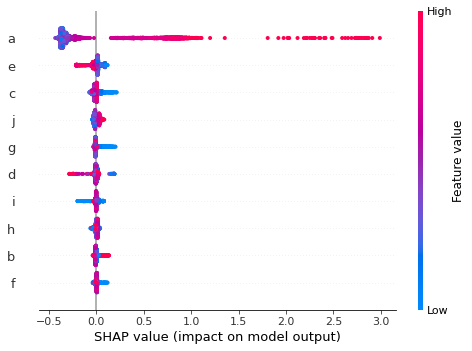

In [17]:
shap.summary_plot(shap_values["Y0"]["T0"])

# DRLearner

In [18]:
model_regression = clone(first_stage_reg().fit(np.hstack([T.reshape(-1, 1), X]), Y).best_estimator_)
model_regression

GradientBoostingRegressor(min_samples_leaf=30, n_estimators=50,
                          random_state=123)

In [19]:
from econml.drlearner import ForestDRLearner
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDRLearner(model_regression=model_regression,
                      model_propensity=model_t,
                      n_crossfit_splits=3,
                      n_estimators=4000,
                      subsample_fr='auto',
                      min_samples_leaf=10,
                      verbose=0,
                      min_weight_fraction_leaf=.005)
est.fit(Y, T, X=X)

In [20]:
from econml.drlearner import DRLearner
est2 = DRLearner(model_regression=model_regression,
                 model_propensity=model_t,
                 model_final=final_stage(),
                 n_splits=3)
est2.fit(Y, T, X=X)

In [21]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [22]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [23]:
pred2 = est2.effect(X_test)

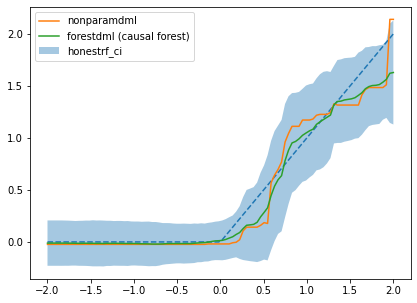

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), '--')
plt.plot(X_test[:, 0], pred2, label='nonparamdml')
plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4, label='honestrf_ci')
plt.legend()
plt.show()

### First stage nuisance models

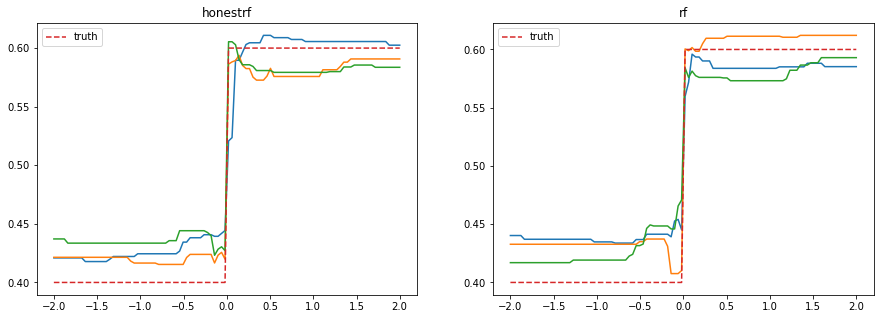

In [25]:
# Model T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_propensity:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_propensity:
    plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), '--', label='truth')
plt.legend()
plt.show()

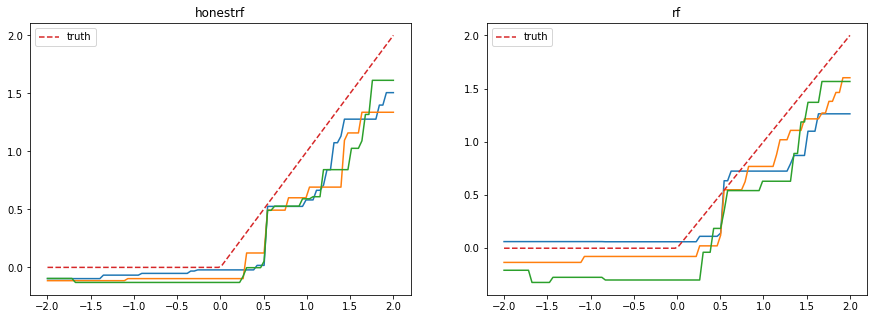

In [26]:
# Model Y
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('honestrf')
for mdl in est.models_regression:
    plt.plot(X_test[:, 0], mdl.predict(np.hstack([X_test, np.ones((X_test.shape[0], 1))])))
plt.plot(X_test[:, 0], true_effect(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('rf')
for mdl in est2.models_regression:
    plt.plot(X_test[:, 0], mdl.predict(np.hstack([X_test, np.ones((X_test.shape[0], 1))])))
plt.plot(X_test[:, 0], true_effect(X_test) + true_conf(X_test), '--', label='truth')
plt.legend()
plt.show()

### Interpretability of CATE Model of DRLearner with SHAP

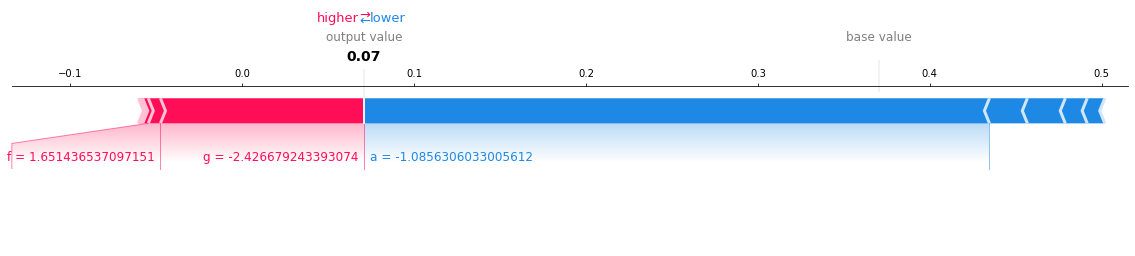

In [27]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_values["Y0"]["T0"][0], matplotlib=True)

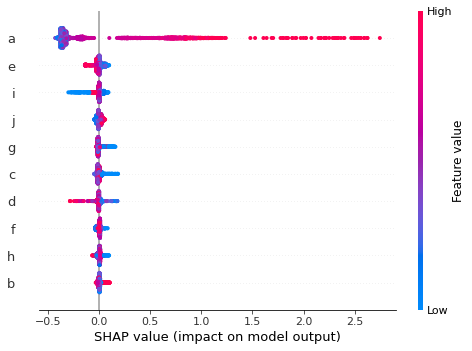

In [28]:
shap.summary_plot(shap_values["Y0"]["T0"])

# OrthoForest and CausalForest

In [29]:
from econml.ortho_forest import DROrthoForest
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from econml.sklearn_extensions.linear_model import WeightedLassoCV

est3 = DROrthoForest(model_Y=Lasso(alpha=0.01),
                     propensity_model=LogisticRegression(C=1),
                     model_Y_final=WeightedLassoCV(cv=3),
                     propensity_model_final=LogisticRegressionCV(cv=3),
                     n_trees=1000, min_leaf_size=10)
est3.fit(Y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


In [30]:
pred3 = est3.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.4s finished


In [31]:
from econml.causal_forest import CausalForest
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from econml.sklearn_extensions.linear_model import WeightedLassoCV

est4 = CausalForest(model_Y=model_y,
                    model_T=model_t,
                    n_trees=1000, min_leaf_size=10,
                    discrete_treatment=True,
                    cv=5)
est4.fit(Y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:    9.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.9s finished


In [32]:
pred4 = est4.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.5s finished


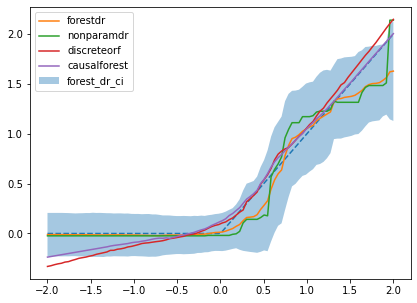

In [33]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), '--')
plt.plot(X_test[:, 0], pred, label='forestdr')
plt.plot(X_test[:, 0], pred2, label='nonparamdr')
plt.plot(X_test[:, 0], pred3, label='discreteorf')
plt.plot(X_test[:, 0], pred4, label='causalforest')
plt.fill_between(X_test[:, 0], lb, ub, alpha=.4, label='forest_dr_ci')
plt.legend()
plt.show()